**AutoRec Project**

# Imports

In [1]:
%matplotlib inline

In [2]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.3 MB/s 


In [3]:
from google.colab import drive
import os

# keras
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Lambda,Activation
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
import tensorflow as tf
import keras_tuner as kt

# sklearn
from sklearn.model_selection import train_test_split

# pytorch
# import torch
# from torch import nn

import requests
import zipfile
import copy

import pandas as pd
import numpy as np
import random
import math

from matplotlib import pyplot as plt

In [4]:
np.random.seed(123)
random.seed(123)

# Metrics

In [5]:
class my_metrics():
    
    THRESHOLD = 3

    def RMSE(y_true, y_pred, lower_bound=1, upper_bound=5):
        y_pred[y_pred<lower_bound] = lower_bound
        y_pred[y_pred>upper_bound] = upper_bound
        rel_preds = (y_true >= lower_bound) & (y_true <= upper_bound)
        return np.sqrt(((rel_preds * (y_true - y_pred))**2).sum() / rel_preds.sum())
    
    def MRR(df_true, df_pred, lower_bound=1, upper_bound=5, top_n=5, threshold_val=THRESHOLD):
        # please use MRR_for_user
        user_mrr = []
        for i in range(df_true.shape[0]):
            val = my_metrics.MRR_for_user(df_true[i,:], df_pred[i,:], lower_bound, upper_bound, top_n, threshold_val)
            if val is not None:
                user_mrr.append(val)
        return np.sum(user_mrr)/len(user_mrr)
    
    def MRR_for_user(user_true, user_pred, lower_bound, upper_bound, top_n, threshold_val):
        rel_preds = (user_true >= lower_bound) & (user_true <= upper_bound)
        if rel_preds.sum() == 0:
            return None
        screened_user_true = user_true[rel_preds]
        screened_user_pred = user_pred[rel_preds]

        top_n_pred_indicies = screened_user_pred.argsort()[::-1][:top_n]
        for i, (pred, actual) in enumerate(zip(screened_user_pred[top_n_pred_indicies], screened_user_true[top_n_pred_indicies])):
            if actual >= threshold_val:
                return 1.0/(i+1)
        
        return 0.0

    def NDCG(df_true, df_pred, lower_bound=1, upper_bound=5, top_n=5):
        # please use NDCG_for_user
        user_ndcg = []
        for i in range(df_true.shape[0]):
            user_ndcg.append(my_metrics.NDCG_for_user(df_true[i], df_pred[i], lower_bound, upper_bound, top_n))
        
        user_ndcg = [x for x in user_ndcg if math.isnan(x) == False]

        return np.sum(user_ndcg) / len(user_ndcg)
        
    def NDCG_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5):
        # please use DCG function
        rel_preds = (user_true >= lower_bound) & (user_true <= upper_bound)
        if rel_preds.astype(bool).sum() < top_n:
            return np.nan        
        screened_user_true = user_true[rel_preds]
        screened_user_pred = user_pred[rel_preds]
        top_n_pred_indicies = screened_user_pred.argsort()[::-1][:top_n]
        user_dcg = my_metrics.DCG(screened_user_true[top_n_pred_indicies])
        user_idcg = my_metrics.DCG(np.sort(screened_user_true[top_n_pred_indicies])[::-1])
        return user_dcg / user_idcg
    
    def DCG(rel):
        # please implement the DCG formula
        dcg = rel[0]
        for i in range(1, len(rel)):
            dcg += rel[i]/np.log2(i+2)

        return dcg
    
    def get_evaluation(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,),'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}

# MovieLens 1M Dataset

## Data Loading & Manipulation

In [6]:
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [7]:
ratings_df = pd.read_csv('/content/ml-1m/ratings.dat', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delimiter='::')
ratings_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


we are not intrested in timestamps, so we can remove the column. <br>
also, in order to keep embedding size as small as possible, we need to change the user and item ids.

In [8]:
ratings_df.drop(columns='timestamp', inplace=True)

def user_id_trans(idx):
    return idx-1

item_id_trans_dict =  {k:v for k,v in zip(ratings_df.item_id.unique(),range(ratings_df.item_id.nunique()))}
def item_id_trans(key_value):
    return item_id_trans_dict[key_value]

ratings_df.user_id = ratings_df.user_id.apply(user_id_trans)
ratings_df.item_id = ratings_df.item_id.apply(item_id_trans)

ratings_df.head()

,user_id,item_id,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [9]:
ml_users_num, ml_items_num = ratings_df.user_id.nunique(), ratings_df.item_id.nunique()
ml_users_num, ml_items_num

(6040, 3706)

## Train\Test Split

splitting the data into train, validation and test:

In [10]:
train, test = train_test_split(ratings_df, test_size=0.1, random_state=42)
train.user_id.nunique(), train.item_id.nunique()

def create_full_mat(df):
    full_mat = np.zeros((ml_users_num, ml_items_num))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

full_train_mat = create_full_mat(train)
full_test_mat = create_full_mat(test)

In [11]:
def df_to_mat(df):
    full_mat = np.zeros((df.user_id.max()+1, df.item_id.max()+1))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

## Matrix Factorization

In [12]:
class MF:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_mf_model.h5', monitor='val_loss', mode='min', save_best_only=True)

    def __init__(self, users_num, items_num, latent_dim=20, optimizer='Adam', loss='mean_squared_error', learning_rate=0.01):
        self.users_num = users_num
        self.items_num = items_num
        self.optimizer = optimizer
        self.loss = loss
        self.learning_rate = learning_rate
        self.latent_dim = latent_dim

    def build_opt_model(self):
        user_input = Input(shape=(1,), name='user_input', dtype='int32')
        item_input = Input(shape=(1,), name='item_input', dtype='int32')

        user_embedding = Embedding(input_dim=self.users_num, output_dim=self.latent_dim, name='user_embedding')(user_input)
        item_embedding = Embedding(input_dim=self.items_num, output_dim=self.latent_dim, name='item_embedding')(item_input)

        user_latent = Flatten()(user_embedding)
        item_latent = Flatten()(item_embedding)

        pred = keras.layers.dot([user_latent, item_latent], axes=1, normalize=False)
        self.model = Model(inputs=[user_input, item_input], outputs=pred)

        if self.optimizer=='Adam':
            self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=self.loss)
        else:
            raise Exception('Optimizer not implemented')
        self.model.summary()

    def model_builder(self, hp):
        user_input = Input(shape=(1,), name='user_input', dtype='int32')
        item_input = Input(shape=(1,), name='item_input', dtype='int32')

        hp_latent_dim = hp.Int('latent_dim', min_value=8, max_value=40, step=8)

        user_embedding = Embedding(input_dim=self.users_num, output_dim=hp_latent_dim, name='user_embedding')(user_input)
        item_embedding = Embedding(input_dim=self.items_num, output_dim=hp_latent_dim, name='item_embedding')(item_input)

        user_latent = Flatten()(user_embedding)
        item_latent = Flatten()(item_embedding)

        pred = keras.layers.dot([user_latent, item_latent], axes=1, normalize=False)
        self.model = Model(inputs=[user_input, item_input], outputs=pred)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        if self.optimizer=='Adam':
            self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=self.loss)
        else:
            raise Exception('Optimizer not implemented')
        self.model.summary()
        return self.model
        
    def fit(self, user_input, item_input, labels, batch_size=8168, epochs=100, verbose=1):
        self.hist = self.model.fit([np.array(user_input), np.array(item_input)], #input
                                np.array(labels), # labels 
                                validation_split=0.1,
                                batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                callbacks=[MF.es, MF.mc]) 
    
    def predict(self, user_input, item_input, batch_size=8168, verbose=1):
        self.predictions = self.model.predict([np.array(user_input), np.array(item_input)], 
                                 batch_size=batch_size, verbose=verbose)

### Hyperparameter Tuning

creating and fitting the model:

In [13]:
mf = MF(users_num=ratings_df.user_id.max()+1, items_num=ratings_df.item_id.max()+1)

In [14]:
tuner = kt.Hyperband(mf.model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyper_params',
                     project_name='mf_ml')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 8)         48320       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 8)         29648       ['item_input[0][0]']             
                                                                                              

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search([np.array(train.user_id), np.array(train.item_id)], np.array(train.rating), 
             epochs=10, validation_split=0.2, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 00m 17s]
val_loss: 0.8040345311164856

Best val_loss So Far: 0.8040345311164856
Total elapsed time: 00h 03m 59s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_hps.get('latent_dim'), best_hps.get('learning_rate')

(40, 0.001)

### Retraining

In [17]:
mf_opt = MF(users_num=ratings_df.user_id.max()+1, items_num=ratings_df.item_id.max()+1, latent_dim=best_hps.get('latent_dim'), learning_rate=best_hps.get('learning_rate'))
mf_opt.build_opt_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 40)        241600      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 40)        148240      ['item_input[0][0]']             
                                                                                            

In [18]:
mf_opt.fit(train.user_id, train.item_id, labels=train.rating)

Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 14.0390 - val_loss: 13.8820
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 11.5933 - val_loss: 7.7712
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 4.2147 - val_loss: 1.9208
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 1.3715 - val_loss: 1.0997
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.9905 - val_loss: 0.9371
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.8911 - val_loss: 0.8798
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.8529 - val_loss: 0.8564
Epoch 8/100
100/100 [==============================] - 0s 4ms/step - loss: 0.8358 - val_loss: 0.8451
Epoch 9/100
100/100 [==============================] - 0s 4ms/step - loss: 0.8270 - val_loss: 0.8394
Epoch 10/100
100/100 [==============================] - 0s 4ms/step - loss: 0.8220 - val

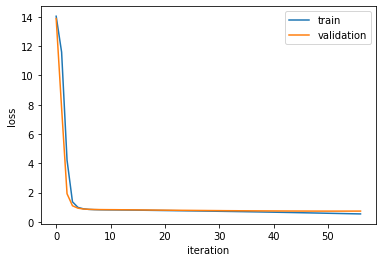

In [19]:
# plot training history
plt.plot(mf_opt.hist.history['loss'], label='train')
plt.plot(mf_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
mf_opt.model = load_model('best_mf_model.h5')

### Prediction

test prediction:

In [21]:
mf_opt.predict(test.user_id, test.item_id)

13/13 [==============================] - 0s 1ms/step


### Evaluation

In [22]:
pred_df = test.copy()
pred_df.rating = mf_opt.predictions.reshape(-1)
pred_mat = df_to_mat(pred_df)
test_mat = df_to_mat(test)

In [23]:
mf_opt_eval = my_metrics.get_evaluation(test_mat, pred_mat)
mf_opt_eval

{'MRR_10': 0.9767420435510887,
 'MRR_5': 0.9767420435510887,
 'NDCG_10': 0.96639506730612,
 'NDCG_5': 0.9709229772978891,
 'RMSE': 0.8605244715552927}

Text(0, 0.5, 'values')

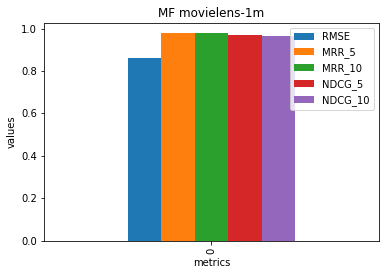

In [24]:
mf_opt_eval_df = pd.DataFrame(mf_opt_eval, index=[0])
mf_opt_eval_df.plot(kind='bar')
plt.title('MF movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

Note that we approximately reached the RMSE described in the paper (0.86 vs. 0.845). Furthermore our implementation uses regular MF where as the paper comparison is Biased-MF based.

## AutoRec

### Data Manipulation

In [25]:
def dataPreprocessor(rating_df):
    train_df, test_df = train_test_split(rating_df, test_size=0.1, random_state=42)
    train_mat = np.zeros((rating_df.user_id.nunique(), rating_df.item_id.nunique()))
    for (user_id, item_id, rating) in zip(train_df.user_id, train_df.item_id, train_df.rating):
        train_mat[user_id, item_id] = rating

    ## tmp ##
    # train_mat_avg = copy.copy(train_mat)
    # avg = np.true_divide(train_mat_avg.sum(1), np.maximum((train_mat_avg!=0).sum(1), 1))
    # inds = np.where(train_mat_avg == 0)
    # train_mat_avg[inds] = np.take(avg, inds[0])

    test_mat = np.zeros((rating_df.user_id.nunique(), rating_df.item_id.nunique()))
    for (user_id, item_id, rating) in zip(test_df.user_id, test_df.item_id, test_df.rating):
        test_mat[user_id, item_id] = rating
    
    return train_mat, test_mat #, train_mat_avg

### Model Creation

In [26]:
class IAutoRec:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_autorec_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    # es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    # mc = ModelCheckpoint('best_autorec_model.h5', monitor='loss', mode='min', save_best_only=True)

    def __init__(self, items_num, hidden_units=500, reg=0.0005, optimizer='Adam', loss='mean_squared_error', learning_rate=0.0001, first_activation='elu', last_activation='elu'):
        self.items_num = items_num
        self.hidden_units = hidden_units
        self.reg = reg
        self.optimizer = optimizer
        self.loss = loss
        self.learning_rate = learning_rate
        self.first_activation = first_activation
        self.last_activation = last_activation
        # input_layer = Input(shape=(rating_mat.shape[1],), name='item_rating')
        # dense = Dense(hidden_units, activation=first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(reg))(input_layer)
        # output_layer = Dense(rating_mat.shape[1], activation=last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(reg))(dense)
        # self.model = Model(input_layer, output_layer)

        # if optimizer=='Adam':
        #     # self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)
        #     self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=self.masked_rmse)
        # else:
        #     raise Exception('Optimizer not implemented')

        # self.model.summary()

    def build_opt_model(self):
        input_layer = Input(shape=(self.items_num,), name='item_rating')
        dense = Dense(self.hidden_units, activation=self.first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(self.reg))(input_layer)
        output_layer = Dense(self.items_num, activation=self.last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(self.reg))(dense)
        self.model = Model(input_layer, output_layer)

        if self.optimizer=='Adam':
            # self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)
            self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=IAutoRec.masked_rmse)
        else:
            raise Exception('Optimizer not implemented')

        self.model.summary()

    def model_builder(self, hp):
        input_layer = Input(shape=(self.items_num,), name='item_rating')
        hp_hidden_units = hp.Int('hidden_units', min_value=300, max_value=800, step=100)
        hp_reg = hp.Choice('reg', values=[0.001, 0.0005, 0.0001])
        hp_first_activation = hp.Choice('first_activation', values=['relu', 'elu', 'sigmoid'])
        hp_last_activation = hp.Choice('last_activation', values=['relu', 'elu', 'sigmoid'])
        dense = Dense(hp_hidden_units, activation=hp_first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(hp_reg))(input_layer)
        output_layer = Dense(self.items_num, activation=hp_last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(hp_reg))(dense)
        self.model = Model(input_layer, output_layer)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        if self.optimizer=='Adam':
            # self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=self.loss)
            self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=IAutoRec.masked_rmse)
        else:
            raise Exception('Optimizer not implemented')

        self.model.summary()
        return self.model

    @staticmethod
    def masked_rmse(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32') 
        e = y_true - y_pred
        se = e * e 
        se = se * mask
        mse = 1.0 * tf.reduce_sum(se) / tf.reduce_sum(mask)
        rmse = tf.math.sqrt(mse)
        return rmse

    def fit(self, rating_mat, rating_mat2,  batch_size=256, epochs=500, verbose=2):
        self.hist = self.model.fit(x=rating_mat,y=rating_mat2,
                                validation_split=0.1,
                                batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                callbacks=[IAutoRec.es, IAutoRec.mc]) 
    
    def predict(self, rating_mat, batch_size=512, verbose=1):
        self.predictions = self.model.predict(rating_mat, 
                                 batch_size=batch_size, verbose=verbose)

### Hyperparameters Tuning

In [27]:
train_mat, test_mat = dataPreprocessor(ratings_df)
autorec = IAutoRec(train_mat.shape[1])
tuner = kt.Hyperband(autorec.model_builder,
                     objective='val_loss',
                     max_epochs=500,
                     directory='hyper_params_',
                     project_name='autorec_ml')


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 latent_dim (Dense)          (None, 300)               1112100   
                                                                 
 item_pred_rating (Dense)    (None, 3706)              1115506   
                                                                 
Total params: 2,227,606
Trainable params: 2,227,606
Non-trainable params: 0
_________________________________________________________________


In [28]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 517 Complete [00h 00m 03s]
val_loss: 3.045590877532959

Best val_loss So Far: 1.014046549797058
Total elapsed time: 00h 18m 49s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_hps.get('hidden_units'), best_hps.get('first_activation'), best_hps.get('last_activation') ,best_hps.get('reg'), best_hps.get('learning_rate')

(300, 'sigmoid', 'elu', 0.0001, 0.001)

### Retraining

In [30]:
autorec_opt = IAutoRec(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), reg=best_hps.get('reg'), 
                       learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                       last_activation=best_hps.get('last_activation'))
autorec_opt.build_opt_model()
autorec_opt.fit(train_mat, train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 latent_dim (Dense)          (None, 300)               1112100   
                                                                 
 item_pred_rating (Dense)    (None, 3706)              1115506   
                                                                 
Total params: 2,227,606
Trainable params: 2,227,606
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
22/22 - 1s - loss: 2.0550 - val_loss: 1.3098 - 745ms/epoch - 34ms/step
Epoch 2/500
22/22 - 0s - loss: 1.1494 - val_loss: 1.1090 - 175ms/epoch - 8ms/step
Epoch 3/500
22/22 - 0s - loss: 1.0805 - val_loss: 1.0813 - 179ms/epoch - 8ms/step
Epoch 4/500
22/22 - 0s - loss: 1.0655 - val_loss: 1.0703 - 178ms/e

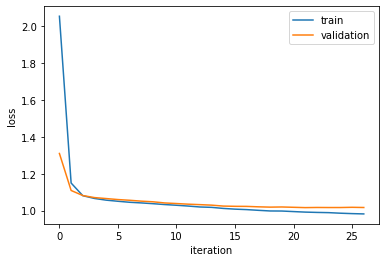

In [31]:
# plot training history
plt.plot(autorec_opt.hist.history['loss'], label='train')
plt.plot(autorec_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [33]:
autorec_opt.model = load_model('best_autorec_model.h5', custom_objects={'masked_rmse': IAutoRec.masked_rmse})


### Prediction

In [34]:
# autorec.predict(np.zeros(test_mat.shape))
autorec_opt.predict(test_mat)

12/12 [==============================] - 0s 4ms/step


### Evaluation

In [35]:
autorec_opt_eval = my_metrics.get_evaluation(test_mat, autorec_opt.predictions)
autorec_opt_eval

{'MRR_10': 0.9687185929648241,
 'MRR_5': 0.9686767169179229,
 'NDCG_10': 0.9583230437019302,
 'NDCG_5': 0.9641297850891174,
 'RMSE': 1.242583839117922}

Text(0, 0.5, 'values')

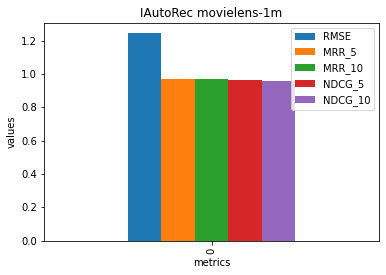

In [36]:
autorec_opt_eval_df = pd.DataFrame(autorec_opt_eval, index=[0])
autorec_opt_eval_df.plot(kind='bar')
plt.title('IAutoRec movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

Note that we did not acheive similar results as the paper. our model's RMSE reaches 1.24 while the paper's reches 0.831. <br> This is quite a big difference, the reasons colud be explained by getting different hyperparameters. 
The paper does not disclose all of the hyperparameters.
It describes some of them, such as regularization, hidden layer size and activation functions. Other parameters such as learning rate are not available, furthermore they use a different train and evaluation mechanism: "We repeat this splitting procedure 5 times and report average RMSE."

## IAutoRec Enhanced

### Model

In [37]:
class IAutoRecEnhanced:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_autorec_enhanced_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    # es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    # mc = ModelCheckpoint('best_autorec_enhanced_model.h5', monitor='loss', mode='min', save_best_only=True)

    def __init__(self, items_num, hidden_units=500, hidden_layer_factor=2, reg=0.0005, optimizer='Adam', loss='mean_squared_error', learning_rate=0.0001, first_activation='elu', last_activation='elu'):
        self.items_num = items_num
        self.hidden_units = hidden_units
        self.hidden_layer_factor = hidden_layer_factor
        self.reg = reg
        self.optimizer = optimizer
        self.loss = loss
        self.learning_rate = learning_rate
        self.first_activation = first_activation
        self.last_activation = last_activation

    def build_opt_model(self):
        input_layer = Input(shape=(self.items_num,), name='item_rating')
        hidden_layer_encoder = Dense(self.hidden_units*self.hidden_layer_factor, activation=self.first_activation, name='hidden_encoder', kernel_regularizer=regularizers.l2(self.reg))(input_layer)
        dense = Dense(self.hidden_units, activation=self.first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(self.reg))(hidden_layer_encoder)
        hidden_layer_decoder = Dense(self.hidden_units*self.hidden_layer_factor, activation=self.last_activation, name='hidden_decoder', kernel_regularizer=regularizers.l2(self.reg))(dense)
        output_layer = Dense(self.items_num, activation=self.last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(self.reg))(hidden_layer_decoder)
        self.model = Model(input_layer, output_layer)

        if self.optimizer=='Adam':
            # self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)
            self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=IAutoRecEnhanced.masked_rmse)
        else:
            raise Exception('Optimizer not implemented')

        self.model.summary()

    def model_builder(self, hp):
        hp_hidden_units = hp.Int('hidden_units', min_value=300, max_value=800, step=100)
        hp_hidden_layer_factor = hp.Choice('hidden_layer_factor', values=[2, 3, 4])
        # hp_reg = hp.Choice('reg', values=[0.01, 0.001, 0.0001])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        hp_reg = hp.Choice('reg', values=[0.001, 0.0005, 0.0001])
        hp_first_activation = hp.Choice('first_activation', values=['relu', 'elu', 'sigmoid'])
        # hp_first_activation = hp.Choice('first_activation', values=['relu', 'sigmoid'])
        hp_last_activation = hp.Choice('last_activation', values=['relu', 'elu', 'sigmoid'])

        input_layer = Input(shape=(self.items_num,), name='item_rating')
        hidden_layer_encoder = Dense(hp_hidden_units*hp_hidden_layer_factor, activation=hp_first_activation, name='hidden_encoder', kernel_regularizer=regularizers.l2(hp_reg))(input_layer)
        dense = Dense(hp_hidden_units, activation=hp_first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(hp_reg))(hidden_layer_encoder)
        hidden_layer_decoder = Dense(hp_hidden_units*hp_hidden_layer_factor, activation=hp_last_activation, name='hidden_decoder', kernel_regularizer=regularizers.l2(hp_reg))(dense)
        output_layer = Dense(self.items_num, activation=hp_last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(hp_reg))(hidden_layer_decoder)
        self.model = Model(input_layer, output_layer)
        
        if self.optimizer=='Adam':
            # self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=self.loss)
            self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=IAutoRecEnhanced.masked_rmse)
        else:
            raise Exception('Optimizer not implemented')

        self.model.summary()
        return self.model

    @staticmethod
    def masked_rmse(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32') 
        e = y_true - y_pred
        se = e * e 
        se = se * mask
        mse = 1.0 * tf.reduce_sum(se) / tf.reduce_sum(mask)
        rmse = tf.math.sqrt(mse)
        return rmse

    def fit(self, rating_mat,rating_mat2, batch_size=256, epochs=500, verbose=2):
        self.hist = self.model.fit(x=rating_mat,y=rating_mat2,
                                validation_split=0.1,
                                batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                callbacks=[IAutoRecEnhanced.es, IAutoRecEnhanced.mc]) 
    
    def predict(self, rating_mat, batch_size=512, verbose=1):
        self.predictions = self.model.predict(rating_mat, 
                                 batch_size=batch_size, verbose=verbose)

### HyperParameters Tuning

In [38]:
autorec_enhanced = IAutoRecEnhanced(train_mat.shape[1])
tuner = kt.Hyperband(autorec_enhanced.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                    #  factor=3,
                     directory='hyper_params',
                     project_name='autorec_enhanced_ml')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder (Dense)      (None, 600)               2224200   
                                                                 
 latent_dim (Dense)          (None, 300)               180300    
                                                                 
 hidden_decoder (Dense)      (None, 600)               180600    
                                                                 
 item_pred_rating (Dense)    (None, 3706)              2227306   
                                                                 
Total params: 4,812,406
Trainable params: 4,812,406
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 326 Complete [00h 00m 04s]
val_loss: 1.7014926671981812

Best val_loss So Far: 1.169392704963684
Total elapsed time: 00h 26m 22s

Search: Running Trial #327

Hyperparameter    |Value             |Best Value So Far 
hidden_units      |500               |300               
hidden_layer_fa...|4                 |2                 
learning_rate     |0.0001            |0.001             
reg               |0.0001            |0.0001            
first_activation  |elu               |sigmoid           
last_activation   |relu              |elu               
tuner/epochs      |7                 |7                 
tuner/initial_e...|3                 |3                 
tuner/bracket     |5                 |5                 
tuner/round       |1                 |1                 
tuner/trial_id    |871d17012fcae09...|6e272c0faced923...

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ite

In [ ]:
best_hps.get('hidden_units'), best_hps.get('hidden_layer_factor'), best_hps.get('first_activation'), best_hps.get('last_activation'), best_hps.get('reg'), best_hps.get('learning_rate')

### Retraining

In [ ]:
autorec_enhanced_opt = IAutoRecEnhanced(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
                                        hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
                                        learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                                        last_activation=best_hps.get('last_activation'))
autorec_enhanced_opt.build_opt_model()
autorec_enhanced_opt.fit(train_mat, train_mat)

In [ ]:
# plot training history
plt.plot(autorec_enhanced_opt.hist.history['loss'], label='train')
plt.plot(autorec_enhanced_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [ ]:
autorec_enhanced_opt.model = load_model('best_autorec_enhanced_model.h5', custom_objects={'masked_rmse': IAutoRecEnhanced.masked_rmse})

### Prediction

In [ ]:
autorec_enhanced_opt.predict(test_mat)

### Evaluation

In [ ]:
autorec_enhanced_opt_eval = my_metrics.get_evaluation(test_mat, autorec_enhanced_opt.predictions)
autorec_enhanced_opt_eval

In [ ]:
autorec_enhanced_opt_eval_df = pd.DataFrame(autorec_enhanced_opt_eval, index=[0])
autorec_enhanced_opt_eval_df.plot(kind='bar')
plt.title('IAutoRec Enhanced movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

## Models Metrics Comparison

In [ ]:
result_dict = {
    'mf': mf_opt_eval,
    'autorec': autorec_opt_eval,
    'autorec_enhanced': autorec_enhanced_opt_eval
               }
res_df = pd.DataFrame.from_dict(result_dict)
res_df

In [ ]:
res_df.plot(kind='bar', figsize=(12,5), rot=45)
plt.title('movielens-1m models results')

In [ ]:
res_df.transpose().plot(kind='bar', figsize=(12,5), rot=45)

# Netflix Prize Dataset

## Data Loading and Manupulation

In [ ]:
drive.mount('/content/drive')

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/rec_sys/datasets/netflix_prize.zip',"r") as zip_ref:
    zip_ref.extractall()

note that we are loading only part of the dataset because of RAM issues.

In [ ]:
if not os.path.isfile('netflix_data.csv'):
    netflix_data = open('netflix_data.csv', mode='w')    
    row = list()
    files=['/content/combined_data_1.txt']
    #,'/content/combined_data_2.txt']#, 
#            '/content/combined_data_3.txt', '/content/combined_data_4.txt']
    for file in files:
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    netflix_data.write(','.join(row))
                    netflix_data.write('\n')
    netflix_data.close()

In [ ]:
netflix_df = pd.read_csv('netflix_data.csv', sep=',', names=['item_id', 'user_id','rating','date'])
# netflix_df.date = pd.to_datetime(netflix_df.date)
netflix_df.drop(columns=['date'], inplace=True)
# netflix_df = netflix_df.sample(frac = 1)
netflix_df = netflix_df.sort_values(by=['user_id'])
netflix_df = netflix_df.iloc[:int(1e6)]
netflix_df.head()

In [ ]:
netflix_df.shape

checking for null values:

In [ ]:
sum(netflix_df.isnull().any())

checking for duplicates:

In [ ]:
sum(netflix_df.duplicated(['item_id','user_id']))

changing ids into indicies:

In [ ]:
user_trans_dict =  {k:v for k,v in zip(netflix_df.user_id.unique(), range(netflix_df.user_id.nunique()))}
item_trans_dict =  {k:v for k,v in zip(netflix_df.item_id.unique(), range(netflix_df.item_id.nunique()))}

def item_trans(key_value):
    return item_trans_dict[key_value]

def user_trans(key_value):
    return user_trans_dict[key_value]

netflix_df.user_id = netflix_df.user_id.apply(user_trans)
netflix_df.item_id = netflix_df.item_id.apply(item_trans)

netflix_df.head()

In [ ]:
netflix_users_num = netflix_df.user_id.nunique()
netflix_items_num = netflix_df.item_id.nunique()
netflix_users_num, netflix_items_num

## Train\Test Split

In [ ]:
train_netflix, test_netflix = train_test_split(netflix_df, test_size=0.1, random_state=42)
test_netflix.user_id.nunique(), test_netflix.item_id.nunique()

def create_full_mat(df):
    full_mat = np.zeros((netflix_users_num, netflix_items_num))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

netflix_full_train_mat = create_full_mat(train_netflix)
netflix_full_test_mat = create_full_mat(test_netflix)

## Matrix Factorization

In [ ]:
mf_netflix = MF(users_num=netflix_df.user_id.max()+1, items_num=netflix_df.item_id.max()+1)

### Hyperparameters Tuning

In [ ]:
tuner = kt.Hyperband(mf_netflix.model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyper_params',
                     project_name='mf_netflix')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search([np.array(train_netflix.user_id), np.array(train_netflix.item_id)], np.array(train_netflix.rating), 
             epochs=10, validation_split=0.2, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
mf_opt_netflix = MF(users_num=netflix_df.user_id.max()+1, items_num=netflix_df.item_id.max()+1, latent_dim=best_hps.get('latent_dim'), learning_rate=best_hps.get('learning_rate'))
mf_opt_netflix.build_opt_model()

In [ ]:
mf_opt_netflix.fit(train_netflix.user_id, train_netflix.item_id, labels=train_netflix.rating)

In [ ]:
# plot training history
plt.plot(mf_opt_netflix.hist.history['loss'], label='train')
plt.plot(mf_opt_netflix.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
mf_opt_netflix.model = load_model('best_mf_model.h5')

test prediction:

In [ ]:
mf_opt_netflix.predict(test_netflix.user_id, test_netflix.item_id)

In [ ]:
pred_df = test_netflix.copy()
pred_df.rating = mf_opt_netflix.predictions.reshape(-1)
pred_mat = df_to_mat(pred_df)
test_mat = df_to_mat(test_netflix)

evaluation:

In [ ]:
netflix_mf_opt_eval = my_metrics.get_evaluation(test_mat, pred_mat)
netflix_mf_opt_eval

## IAutoRec

### Data Processing

In [ ]:
netflix_train_mat, netflix_test_mat = dataPreprocessor(netflix_df)

### Hyperparameters Tuning

In [ ]:
netflix_autorec = IAutoRec(netflix_train_mat.shape[1])
tuner = kt.Hyperband(netflix_autorec.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                     factor=3,
                     directory='hyper_params',
                     project_name='autorec_netflix')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(netflix_train_mat, netflix_train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.get('hidden_units'), best_hps.get('reg'), best_hps.get('learning_rate'), best_hps.get('first_activation'), best_hps.get('last_activation')

### Retraining

In [ ]:
netflix_autorec_opt = IAutoRec(netflix_train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), reg=best_hps.get('reg'), 
                               learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                               last_activation=best_hps.get('last_activation'))
netflix_autorec_opt.build_opt_model()
netflix_autorec_opt.fit(netflix_train_mat, netflix_train_mat)

In [ ]:
# plot training history
plt.plot(netflix_autorec_opt.hist.history['loss'], label='train')
plt.plot(netflix_autorec_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [ ]:
netflix_autorec_opt.model = load_model('best_autorec_model.h5', custom_objects={'masked_rmse': IAutoRec.masked_rmse})

### Prediction

In [ ]:
netflix_autorec_opt.predict(netflix_test_mat)

### Evaluation

In [ ]:
netflix_autorec_opt_eval = my_metrics.get_evaluation(netflix_test_mat, netflix_autorec_opt.predictions)
netflix_autorec_opt_eval

## IAutoRec Enhanced

### Hyperparameter Tuning

In [ ]:
netflix_autorec_enhanced = IAutoRecEnhanced(netflix_train_mat.shape[1])
tuner = kt.Hyperband(netflix_autorec_enhanced.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                    #  factor=3,
                     directory='hyper_params',
                     project_name='autorec_enhanced_netflix')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(netflix_train_mat, netflix_train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.get('hidden_units'), best_hps.get('hidden_layer_factor'), best_hps.get('reg'), best_hps.get('learning_rate'), best_hps.get('first_activation'), best_hps.get('last_activation')

### Retraining

In [ ]:
netflix_autorec_enhanced_opt = IAutoRecEnhanced(netflix_train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
                                                hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
                                                learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                                                last_activation=best_hps.get('last_activation'))
netflix_autorec_enhanced_opt.build_opt_model()
netflix_autorec_enhanced_opt.fit(netflix_train_mat, netflix_train_mat)

In [ ]:
# plot training history
plt.plot(netflix_autorec_enhanced_opt.hist.history['loss'], label='train')
plt.plot(netflix_autorec_enhanced_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [ ]:
netflix_autorec_enhanced_opt.model = load_model('best_autorec_enhanced_model.h5', custom_objects={'masked_rmse': IAutoRecEnhanced.masked_rmse})

### Prediction

In [ ]:
netflix_autorec_enhanced_opt.predict(netflix_test_mat)

### Evaluation

In [ ]:
netflix_autorec_enhanced_opt_eval = my_metrics.get_evaluation(netflix_test_mat, netflix_autorec_enhanced_opt.predictions)
netflix_autorec_enhanced_opt_eval

## Evaluation Summary

In [ ]:
netflix_result_dict = {
    'mf': netflix_mf_opt_eval,
    'autorec': netflix_autorec_opt_eval,
    'autorec_enhanced': netflix_autorec_enhanced_opt_eval
               }
netflix_res_df = pd.DataFrame.from_dict(netflix_result_dict)
netflix_res_df

In [ ]:
netflix_res_df.plot(kind='bar', figsize=(12,5), rot=45)
plt.title('netflix prize models results')

In [ ]:
netflix_res_df.transpose().plot(kind='bar', figsize=(12,5), rot=45)